In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio', 'Date'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2020-09-01 04:28:31  33.93911   
1   NaN    NaN            NaN        Albania  2020-09-01 04:28:31  41.15330   

       Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  67.709953    38165.0  1402.0    29089.0  7674.0  Afghanistan   
1  20.168300     9513.0   284.0     5214.0  4015.0      Albania   

   Incidence_Rate  Case-Fatality_Ratio       Date  
0       98.039112             3.673523 2020-08-31  
1      330.565015             2.985388 2020-08-31

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    5742
unique                    174
top       2020-06-14 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-08-31 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incidence_Rate  Case-Fatality_Ratio       Date  
211             NaN                  NaN 2020-03-12  
212             NaN                  NaN 2020-03-1

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     174
unique                    174
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-08-31 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     194
unique                    194
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-08-31 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2             Province_State Country_Region  \
29        NaN                   NaN                        NaN       Botswana   
163       NaN                   NaN                    Vichada       Colombia   
198       NaN                   NaN  Saint Pierre and Miquelon         France   
323       NaN                   NaN                   Nagasaki          Japan   
361       NaN                   NaN                        NaN     Luxembourg   
...       ...                   ...                        ...            ...   
3186      NaN                   NaN       Prince Edward Island         Canada   
3187      NaN                   NaN      Northwest Territories         Canada   
3188      NaN                   NaN           Diamond Princess         Canada   
3415  11001.0  District of Columbia       District of Columbia             US   
3416  53023.0       Garfield County                 Washington             US   

              Last_Update        Lat       Long_  Confirmed  Deaths  \
29    2020-09-01 04:28:31 -22.328500   24.684900     1633.0     6.0   
163   2020-09-01 04:28:31   4.423400  -69.287800       21.0     1.0   
198   2020-09-01 04:28:31  46.885200  -56.315900        5.0     0.0   
323   2020-09-01 04:28:31  33.235712  129.608033      229.0     3.0   
361   2020-09-01 04:28:31  49.815300    6.129600     6625.0   124.0   
...                   ...        ...         ...        ...     ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0     0.0   
3187        3/22/20 23:48        NaN         NaN        1.0     0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0     1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0     2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0     2.0   

      Recovered  Active                                  Combined_Key  \
29        224.0  1225.0                                      Botswana   
163         5.0    73.0                             Vichada, Colombia   
198         1.0     1.0             Saint Pierre and Miquelon, France   
323        36.0    48.0                               Nagasaki, Japan   
361      7140.0  6553.0                                    Luxembourg   
...         ...     ...                                           ...   
3186        0.0     0.0                  Prince Edward Island, Canada   
3187        0.0     0.0                 Northwest Territories, Canada   
3188        0.0     0.0                      Diamond Princess, Canada   
3415        0.0     0.0  District of Columbia,District of Columbia,US   
3416        0.0     0.0                 Garfield County,Washington,US   

      Incidence_Rate  Case-Fatality_Ratio       Date  
29         73.311008             0.367422 2020-08-31  
163        88.119620             4.761905 2020-08-31  
198        86.281277             0.000000 2020-08-31  
323        17.413933             1.310044 2020-08-31  
361      1066.654313             1.871698 2020-08-31  
...              ...                  ...        ...  
3186             NaN                  NaN 2020-03-22  
3187             NaN                  NaN 2020-03-22  
3188             NaN                  NaN 2020-03-22  
3415             NaN                  NaN 2020-03-22  
3416             NaN                  NaN 2020-03-22  

[44283 rows x 15 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34092 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            34092 non-null  float64
 1   Deaths               34092 non-null  float64
 2   Recovered            34092 non-null  float64
 3   Active               34092 non-null  float64
 4   Incidence_Rate       34092 non-null  float64
 5   Case-Fatality_Ratio  34092 non-null  float64
dtypes: float64(6)
memory usage: 1.7+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                             
 Azerbaijan    2020-02-28             0.0                  0.0  
Afghanistan    2020-02-24             0.0                  0.0  
               2020-02-25             0.0                  0.0  
               2020-02-26             0.0                  0.0  
               2020-02-27             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'Brazil', 'India', 'Russia', 'Peru', 'South Africa', 'Colombia',
       'Mexico', 'Spain', 'Argentina', 'Chile', 'Iran', 'United Kingdom',
       'France', 'Saudi Arabia', 'Bangladesh', 'Pakistan', 'Turkey', 'Italy',
       'Iraq', 'Philippines', 'Germany', 'Indonesia', 'Canada', 'Ukraine',
       'Qatar', 'Bolivia', 'Israel', 'Ecuador', 'Kazakhstan', 'Egypt',
       'Dominican Republic', 'Panama', 'China', 'Romania', 'Sweden', 'Oman',
       'Belgium', 'Kuwait', 'Guatemala', 'Netherlands', 'Belarus',
       'United Arab Emirates', 'Japan', 'Poland', 'Morocco', 'Honduras',
       'Portugal', 'Singapore', 'Nigeria'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9667 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2020-08-31 00:00:00'))
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            9667 non-null   float64
 1   Deaths               9667 non-null   float64
 2   Recovered            9667 non-null   float64
 3   Active               9667 non-null   float64
 4   Incidence_Rate       9667 non-null   float64
 5   Case-Fatality_Ratio  9667 non-null   float64
 6   Confirmed_per_100k   9667 non-null   float64
 7   Deaths_per_100k      9667 non-null   float64
 8   Recovered_per_100k   9667 non-null   float64
 9   Active_per_100k      9667 non-null   float64
dtypes: float64(10)
memory usage: 796.7+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                              
Argentina      2020-03-03             0.0                  0.0   
               2020-03-04             0.0                  0.0   
               2020-03-05             0.0                  0.0   
               2020-03-06             0.0                  0.0   
               2020-03-07             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03            0.002233              0.0   
               2020-03-04            0.002233              0.0   
               2020-03-05            0.002233              0.0   
               2020-03-06            0.004466              0.0   
               2020-03-07            0.017865              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 0.0         0.002233  
               2020-03-04                 0.0         0.002233  
               2020-03-05                 0.0         0.002233  
               2020-03-06                 0.0         0.004466  
               2020-03-07                 0.0         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incidence_Rate           50 non-null     float64
 5   Case-Fatality_Ratio      50 non-null     float64
 6   Confirmed_per_100k       50 non-null     float64
 7   Deaths_per_100k          50 non-null     float64
 8   Recovered_per_100k       50 non-null     float64
 9   Active_per_100k          50 non-null     float64
 10  population               50 non-null     float64
 11  recovered_per_confirmed  50 non-null     float64
 12  deaths_per_confirmed     50 non-null     float64
dtypes: float64(13)
memory usage: 5.5+ KB


Confirmed    Deaths  Recovered     Active  \
Country_Region                                                    
Argentina              417735.0    8660.0   301195.0   140862.0   
Bangladesh             312996.0    4281.0   204887.0   115779.0   
Belarus                 71843.0     681.0    70468.0    25477.0   
Belgium                 85236.0    9996.0    18422.0    56919.0   
Bolivia                116598.0    5027.0    60408.0    60928.0   
Brazil                3908272.0  121381.0  3268591.0   598313.0   
Canada                 130918.0    9173.0   116020.0    36033.0   
Chile                  411726.0   11289.0   383879.0    95631.0   
China                   89914.0    4723.0    84594.0    58046.0   
Colombia               615094.0   19662.0   459460.0   169326.0   
Dominican Republic      94715.0    1710.0    68082.0    35057.0   
Ecuador                113767.0    6556.0   101669.0    44283.0   
Egypt                   98939.0    5421.0    72929.0    55230.0   
France                 318986.0   30640.0    86790.0   201556.0   
Germany                218508.0    9203.0   197382.0    72864.0   
Guatemala               74074.0    2760.0    62068.0    27377.0   
Honduras                61014.0    1873.0    10396.0    48745.0   
India                 3691166.0   65288.0  2839882.0   785996.0   
Indonesia              174796.0    7417.0   125959.0    41420.0   
Iran                   375212.0   21571.0   323233.0    34887.0   
Iraq                   234934.0    7042.0   176602.0    51924.0   
Israel                 116596.0     939.0    95009.0    36378.0   
Italy                  269214.0   35483.0   208536.0   108257.0   
Japan                   68396.0    1298.0    56338.0    17240.0   
Kazakhstan             105872.0    1523.0    96297.0    34497.0   
Kuwait                  85109.0     531.0    77224.0    15831.0   
Mexico                 599560.0   64414.0   496222.0    53350.0   
Morocco                 62590.0    1141.0    47595.0    15280.0   
Netherlands             73232.0    6252.0     1010.0    65970.0   
Nigeria                 54008.0    1013.0    41638.0    22707.0   
Oman                    85722.0     685.0    80810.0    23276.0   
Pakistan               295849.0    6294.0   280682.0   108642.0   
Panama                  92982.0    2002.0    66173.0    25172.0   
Peru                   647166.0   28788.0   455457.0   168092.0   
Philippines            220819.0    3558.0   157562.0    83109.0   
Poland                  67372.0    2039.0    46638.0    18695.0   
Portugal                58012.0    1822.0    41961.0    24065.0   
Qatar                  118778.0     197.0   115667.0    35634.0   
Romania                 87540.0    3621.0    37869.0    46050.0   
Russia                 992402.0   17128.0   807339.0   245382.0   
Saudi Arabia           315772.0    3897.0   290796.0    63026.0   
Singapore               56812.0      27.0    55658.0    20799.0   
South Africa           627041.0   14149.0   540923.0   173590.0   
Spain                  462858.0   29094.0   150376.0   283388.0   
Sweden                  87072.0    5821.0     4971.0    81255.0   
Turkey                 270133.0    6370.0   244926.0    80808.0   
US                    6030587.0  183597.0  2184825.0  3662165.0   
Ukraine                124132.0    2605.0    59162.0    62365.0   
United Arab Emirates    70231.0     384.0    60931.0    17173.0   
United Kingdom         338083.0   46791.0     1682.0   294812.0   

                      Incidence_Rate  Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region                                                                  
Argentina               9.242788e+02             3.372463          932.846591   
Bangladesh              1.900523e+02             1.378491          191.967707   
Belarus                 7.602980e+02             0.947900          760.049634   
Belgium                 7.354515e+02            16.247214          738.656660   
Bolivia                 9.988667e+02             4.

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                           
US                    6030587.0  183597.0
Brazil                3908272.0  121381.0
India                 3691166.0   65288.0
Russia                 992402.0   17128.0
Peru                   647166.0   28788.0
South Africa           627041.0   14149.0
Colombia               615094.0   19662.0
Mexico                 599560.0   64414.0
Spain                  462858.0   29094.0
Argentina              417735.0    8660.0
Chile                  411726.0   11289.0
Iran                   375212.0   21571.0
United Kingdom         338083.0   46791.0
France                 318986.0   30640.0
Saudi Arabia           315772.0    3897.0
Bangladesh             312996.0    4281.0
Pakistan               295849.0    6294.0
Turkey                 270133.0    6370.0
Italy                  269214.0   35483.0
Iraq                   234934.0    7042.0
Philippines            220819.0    3558.0
Germany                218508.0    9203.0
Indonesia              174796.0    7417.0
Canada                 130918.0    9173.0
Ukraine                124132.0    2605.0
Qatar                  118778.0     197.0
Bolivia                116598.0    5027.0
Israel                 116596.0     939.0
Ecuador                113767.0    6556.0
Kazakhstan             105872.0    1523.0
Egypt                   98939.0    5421.0
Dominican Republic      94715.0    1710.0
Panama                  92982.0    2002.0
China                   89914.0    4723.0
Romania                 87540.0    3621.0
Sweden                  87072.0    5821.0
Oman                    85722.0     685.0
Belgium                 85236.0    9996.0
Kuwait                  85109.0     531.0
Guatemala               74074.0    2760.0
Netherlands             73232.0    6252.0
Belarus                 71843.0     681.0
United Arab Emirates    70231.0     384.0
Japan                   68396.0    1298.0
Poland                  67372.0    2039.0
Morocco                 62590.0    1141.0
Honduras                61014.0    1873.0
Portugal                58012.0    1822.0
Singapore               56812.0      27.0
Nigeria                 54008.0    1013.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k  Confirmed    Deaths
Country_Region                                               
Qatar                        4194.033271   118778.0     197.0
Panama                       2189.645915    92982.0    2002.0
Chile                        2172.463274   411726.0   11289.0
Kuwait                       2022.996014    85109.0     531.0
Peru                         1990.639198   647166.0   28788.0
Brazil                       1851.827011  3908272.0  121381.0
US                           1832.643557  6030587.0  183597.0
Oman                         1723.058047    85722.0     685.0
Israel                       1368.598370   116596.0     939.0
Colombia                     1221.892741   615094.0   19662.0
South Africa                 1070.798424   627041.0   14149.0
Bolivia                      1012.741831   116598.0    5027.0
Spain                         990.350598   462858.0   29094.0
Singapore                     978.784334    56812.0      27.0
Argentina                     932.846591   417735.0    8660.0
Saudi Arabia                  921.463539   315772.0    3897.0
Dominican Republic            881.975782    94715.0    1710.0
Sweden                        867.562852    87072.0    5821.0
Belarus                       760.049634    71843.0     681.0
Belgium                       738.656660    85236.0    9996.0
United Arab Emirates          718.804699    70231.0     384.0
Russia                        680.322633   992402.0   17128.0
Ecuador                       654.824715   113767.0    6556.0
Honduras                      626.034066    61014.0    1873.0
Iraq                          597.647573   234934.0    7042.0
Kazakhstan                    570.694612   105872.0    1523.0
Portugal                      567.289167    58012.0    1822.0
United Kingdom                500.640003   338083.0   46791.0
France                        489.770179   318986.0   30640.0
Mexico                        469.964738   599560.0   64414.0
Iran                          452.532123   375212.0   21571.0
Romania                       452.062991    87540.0    3621.0
Italy                         444.613693   269214.0   35483.0
Netherlands                   428.329374    73232.0    6252.0
Guatemala                     421.318438    74074.0    2760.0
Canada                        349.944848   130918.0    9173.0
Turkey                        323.785536   270133.0    6370.0
Ukraine                       282.158947   124132.0    2605.0
India                         270.134517  3691166.0   65288.0
Germany                       261.632817   218508.0    9203.0
Philippines                   204.241490   220819.0    3558.0
Bangladesh                    191.967707   312996.0    4281.0
Poland                        177.819909    67372.0    2039.0
Morocco                       171.612200    62590.0    1141.0
Pakistan                      136.609594   295849.0    6294.0
Egypt                          98.556526    98939.0    5421.0
Indonesia                      64.589611   174796.0    7417.0
Japan                          53.914424    68396.0    1298.0
Nigeria                        26.874518    54008.0    1013.0
China                           6.271099    89914.0    4723.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                 
United Kingdom         338083.0   46791.0              0.138401
Italy                  269214.0   35483.0              0.131802
Belgium                 85236.0    9996.0              0.117274
Mexico                 599560.0   64414.0              0.107435
France                 318986.0   30640.0              0.096054
Netherlands             73232.0    6252.0              0.085373
Canada                 130918.0    9173.0              0.070067
Sweden                  87072.0    5821.0              0.066853
Spain                  462858.0   29094.0              0.062857
Ecuador                113767.0    6556.0              0.057627
Iran                   375212.0   21571.0              0.057490
Egypt                   98939.0    5421.0              0.054791
China                   89914.0    4723.0              0.052528
Peru                   647166.0   28788.0              0.044483
Bolivia                116598.0    5027.0              0.043114
Indonesia              174796.0    7417.0              0.042432
Germany                218508.0    9203.0              0.042117
Romania                 87540.0    3621.0              0.041364
Guatemala               74074.0    2760.0              0.037260
Colombia               615094.0   19662.0              0.031966
Portugal                58012.0    1822.0              0.031407
Brazil                3908272.0  121381.0              0.031057
Honduras                61014.0    1873.0              0.030698
US                    6030587.0  183597.0              0.030444
Poland                  67372.0    2039.0              0.030265
Iraq                   234934.0    7042.0              0.029974
Chile                  411726.0   11289.0              0.027419
Turkey                 270133.0    6370.0              0.023581
South Africa           627041.0   14149.0              0.022565
Panama                  92982.0    2002.0              0.021531
Pakistan               295849.0    6294.0              0.021274
Ukraine                124132.0    2605.0              0.020986
Argentina              417735.0    8660.0              0.020731
Japan                   68396.0    1298.0              0.018978
Nigeria                 54008.0    1013.0              0.018756
Morocco                 62590.0    1141.0              0.018230
Dominican Republic      94715.0    1710.0              0.018054
India                 3691166.0   65288.0              0.017688
Russia                 992402.0   17128.0              0.017259
Philippines            220819.0    3558.0              0.016113
Kazakhstan             105872.0    1523.0              0.014385
Bangladesh             312996.0    4281.0              0.013677
Saudi Arabia           315772.0    3897.0              0.012341
Belarus                 71843.0     681.0              0.009479
Israel                 116596.0     939.0              0.008053
Oman                    85722.0     685.0              0.007991
Kuwait                  85109.0     531.0              0.006239
United Arab Emirates    70231.0     384.0              0.005468
Qatar                  118778.0     197.0              0.001659
Singapore               56812.0      27.0              0.000475

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Confirmed_per_100k', 'Deaths_per_100k',
       'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

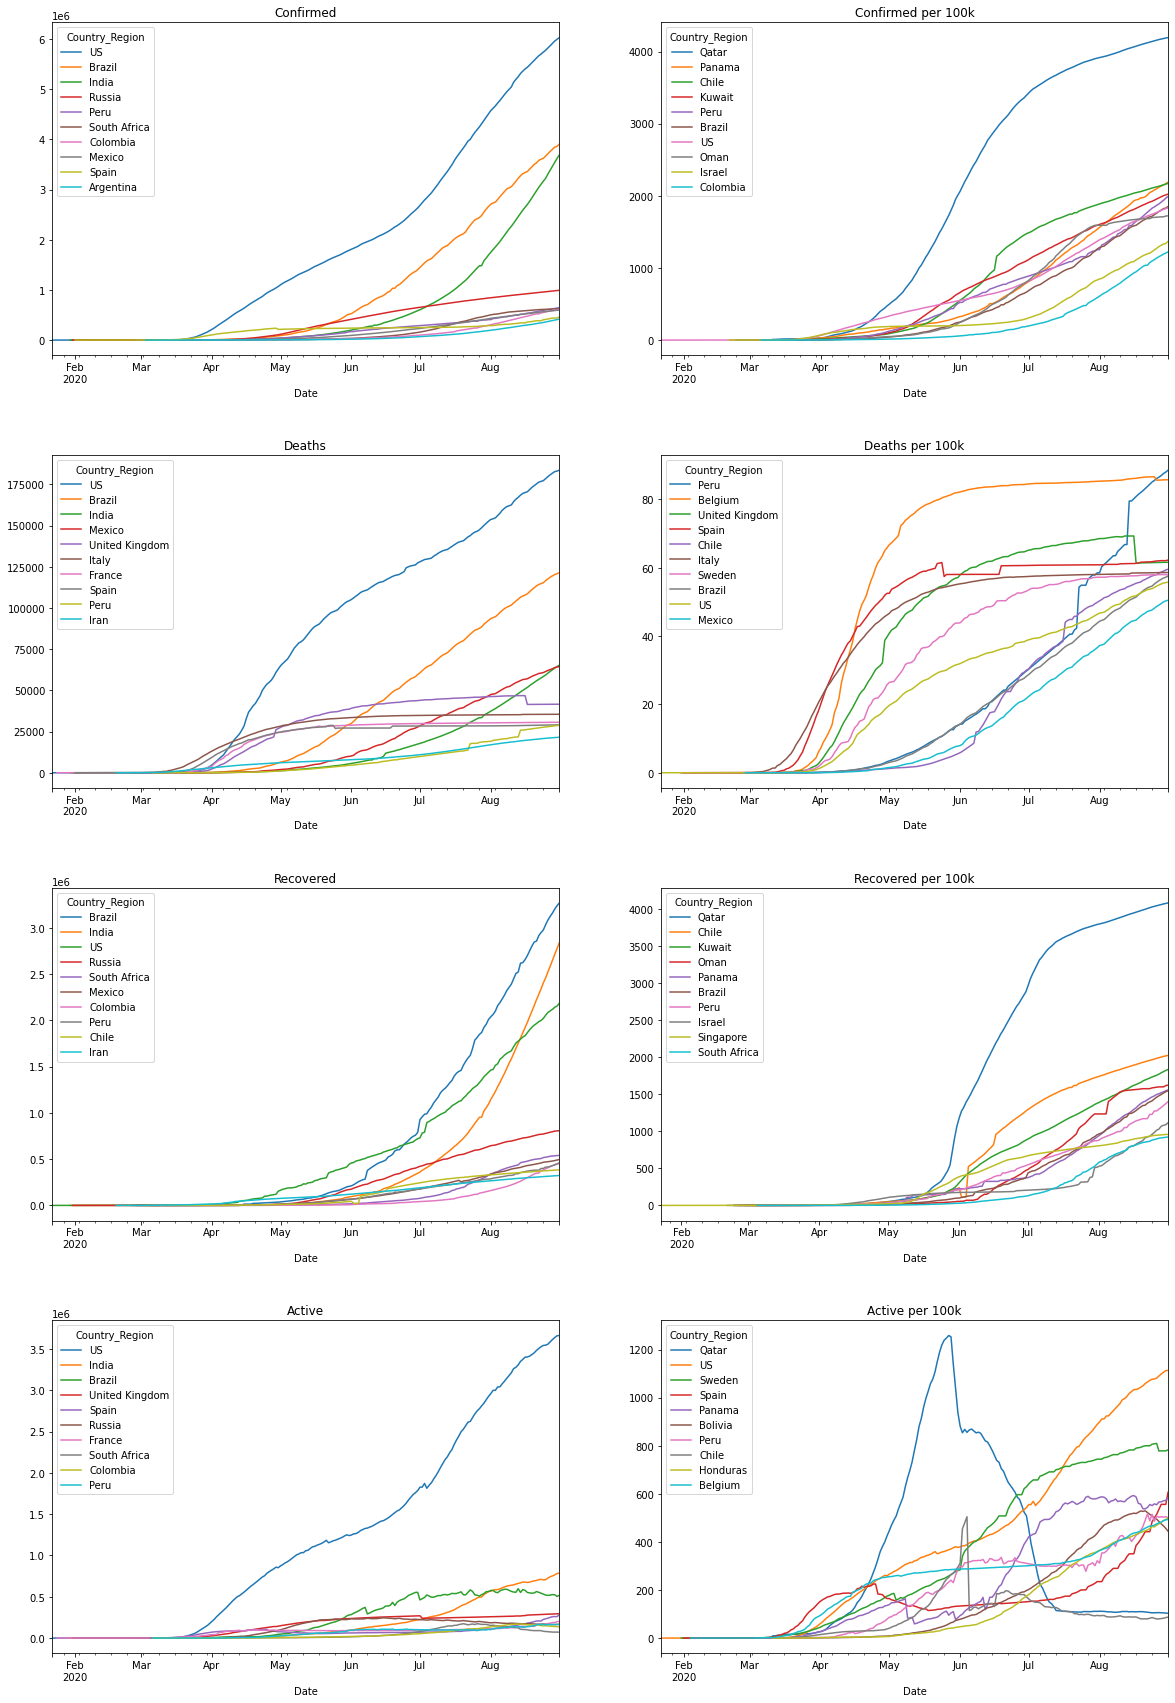

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

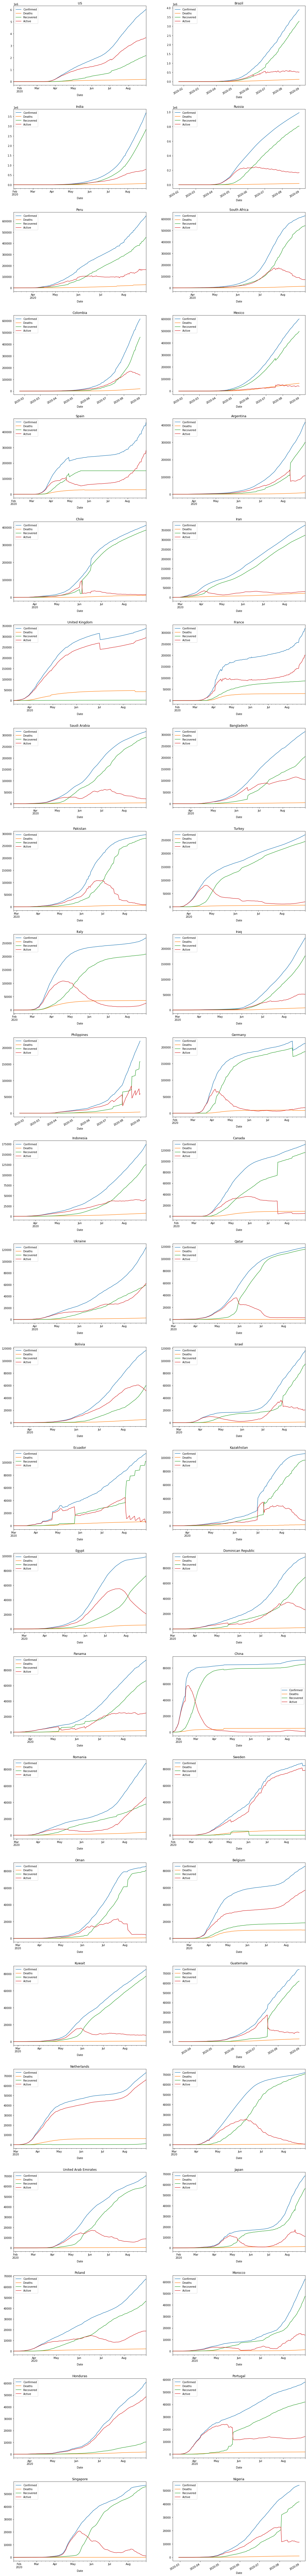

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-08-27     1182.8    11.0        3.4   
                              2020-08-28     1232.6    11.6       13.6   
                              2020-08-29     1259.2    13.2       14.4   
                              2020-08-30     1369.4    10.2       14.6   
                              2020-08-31     1423.2     7.4       26.2   

                                          Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                     
Argentina      Argentina      2020-03-03     NaN                 NaN   
                              2020-03-04     NaN                 NaN   
                              2020-03-05     NaN                 NaN   
                              2020-03-06     NaN                 NaN   
                              2020-03-07     NaN                 NaN   
...                                          ...                 ...   
United Kingdom United Kingdom 2020-08-27  1168.4            1.751514   
                              2020-08-28  1207.4            1.825258   
                              2020-08-29  1231.6            1.864648   
                              2020-08-30  1344.6            2.027835   
                              2020-08-31  1389.6            2.107503   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03              NaN                 NaN   
                              2020-03-04              NaN                 NaN   
                              2020-03-05              NaN                 NaN   
                              2020-03-06              NaN                 NaN   
                              2020-03-07              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-08-27         0.016289            0.005035   
                              2020-08-28         0.017178            0.020139   
                              2020-08-29         0.019547            0.021324   
                              2020-08-30         0.015104            0.021620   
                              2020-08-31         0.010958            0.038797   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Argentina      Argentina      2020-03-03              NaN  
                              2020-03-04              NaN  
                              2020-03-05              NaN  
                              2020-03-06              NaN  
                              2020-03-07              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-08-27         1.730190  
                              2020-08-28         1.787942  
                              2020-08-29         1.823778  
                              2020-08-30         1.991110  
                              2020-08-31         2.057747  

[9667 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        NaN     NaN        NaN     NaN   
               2020-03-04        NaN     NaN        NaN     NaN   
               2020-03-05        NaN     NaN        NaN     NaN   
               2020-03-06        NaN     NaN        NaN     NaN   
               2020-03-07        NaN     NaN        NaN     NaN   
...                              ...     ...        ...     ...   
United Kingdom 2020-08-27     1182.8    11.0        3.4  1168.4   
               2020-08-28     1232.6    11.6       13.6  1207.4   
               2020-08-29     1259.2    13.2       14.4  1231.6   
               2020-08-30     1369.4    10.2       14.6  1344.6   
               2020-08-31     1423.2     7.4       26.2  1389.6   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-08-27            1.751514         0.016289   
               2020-08-28            1.825258         0.017178   
               2020-08-29            1.864648         0.019547   
               2020-08-30            2.027835         0.015104   
               2020-08-31            2.107503         0.010958   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-08-27            0.005035         1.730190  
               2020-08-28            0.020139         1.787942  
               2020-08-29            0.021324         1.823778  
               2020-08-30            0.021620         1.991110  
               2020-08-31            0.038797         2.057747  

[9667 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

182

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-08-27     8698.0   240.4     5735.4  2722.2   
               2020-08-28     9971.0   257.2     5753.0  3960.8   
               2020-08-29    10074.4   197.4     6086.2  3790.8   
               2020-08-30     9757.6   178.8     6161.0  3417.8   
               2020-08-31     9509.4   164.2     6478.8  2866.4   
Bangladesh     2020-03-08        NaN     NaN        NaN     NaN   
               2020-03-09        NaN     NaN        NaN     NaN   
               2020-03-10        NaN     NaN        NaN     NaN   
               2020-03-11        NaN     NaN        NaN     NaN   
               2020-03-12        NaN     NaN        NaN     NaN   
               2020-03-13        0.0     0.0        0.0     0.0   
               2020-03-14        0.0     0.0        0.0     0.0   
               2020-03-15        0.4     0.0        0.0     0.4   
               2020-03-16        1.0     0.0        0.4     0.6   
               2020-03-17        1.4     0.0        0.6     0.8   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-08-27           19.423557         0.536839   
               2020-08-28           22.266301         0.574355   
               2020-08-29           22.497204         0.440815   
               2020-08-30           21.789756         0.399279   
               2020-08-31           21.235499         0.366676   
Bangladesh     2020-03-08                 NaN              NaN   
               2020-03-09                 NaN              NaN   
               2020-03-10                 NaN              NaN   
               2020-03-11                 NaN              NaN   
               2020-03-12                 NaN              NaN   
               2020-03-13            0.000000         0.000000   
               2020-03-14            0.000000         0.000000   
               2020-03-15            0.000245         0.000000   
               2020-03-16            0.000613         0.000000   
               2020-03-17            0.000859         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-08-27           12.807757         6.078962  
               2020-08-28           12.847060         8.844887  
               2020-08-29           13.591131         8.465259  
               2020-08-30           13.758167         7.632310  
               2020-08-31           14.467848         6.400975  
Bangladesh     2020-03-08                 NaN              NaN  
               2020-03-09                 NaN              NaN  
               2020-03-10                 NaN              NaN  
               2020-03-11                 NaN              NaN  
               2020-03-12                 NaN              NaN  
               2020-03-13            0.000000         0.000000  
               2020-03-14            0.000000         0.000000  
               2020-03-15            0.000000         0.000245  
               2020-03-16            0.000245         0.000368  
               2020-03-17            0.000368         0.000491

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112        22.578936   
               2020-05-30           10.692112        24.336391   
               2020-05-31           11.915854        24.510573   
               2020-06-01           12.328979        25.318957   
               2020-06-02           12.748803        26.888831   
               2020-06-03           13.166394        28.559194   
               2020-06-04           13.383005        30.361311   
               2020-06-05           13.595150        31.971381   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Argentina      2020-05-22           516.2         12.0            98.6   
               2020-05-23           596.4         12.6           181.0   
               2020-05-24           653.4         11.8           172.0   
               2020-05-25           669.0         12.8           213.2   
               2020-05-26           659.4         13.6           227.0   
               2020-05-27           656.8         13.4           257.4   
               2020-05-28       

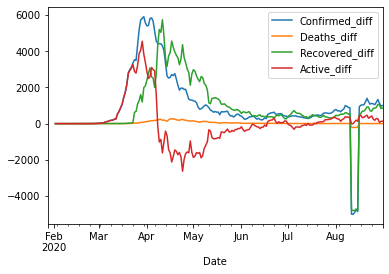

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

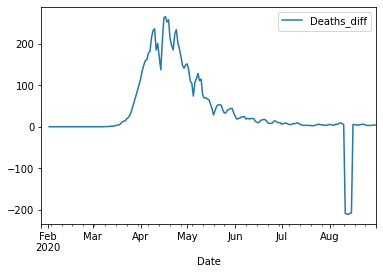

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

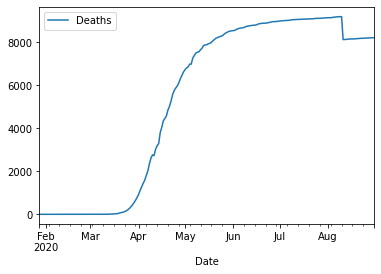

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

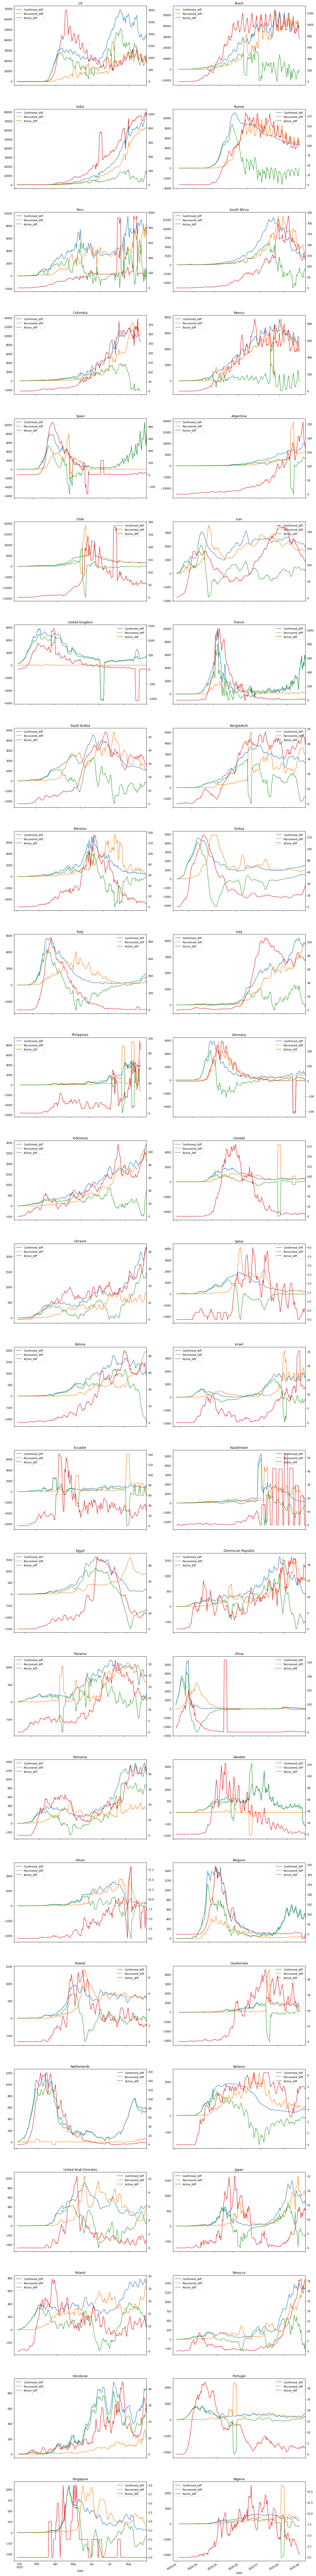

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50